In [12]:
import cv2
import numpy as np
from scipy.cluster.hierarchy import fclusterdata
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


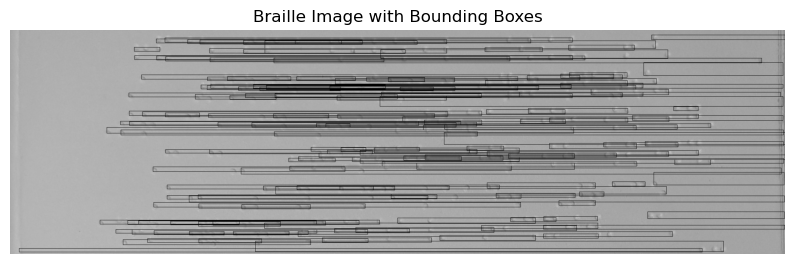

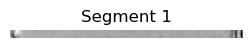

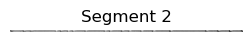

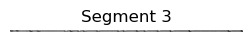

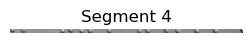

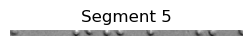

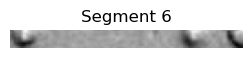

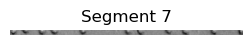

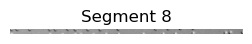

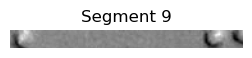

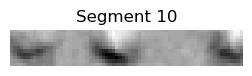

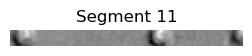

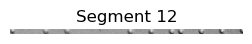

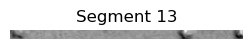

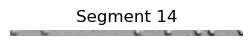

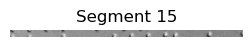

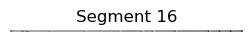

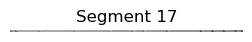

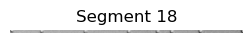

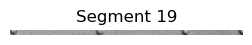

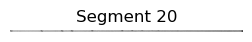

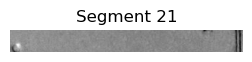

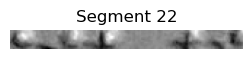

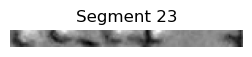

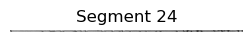

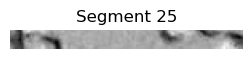

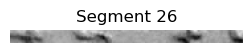

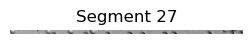

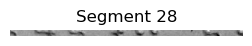

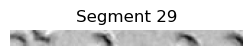

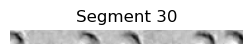

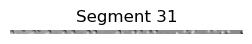

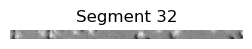

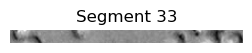

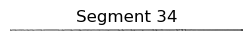

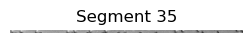

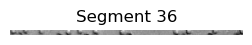

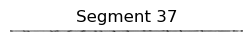

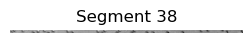

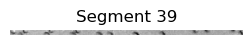

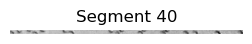

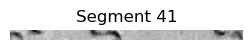

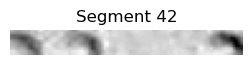

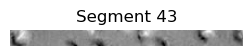

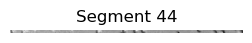

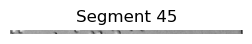

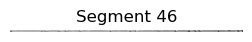

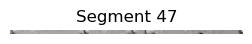

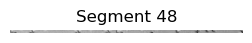

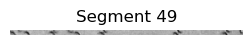

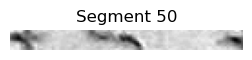

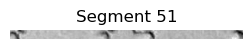

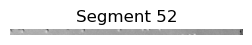

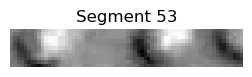

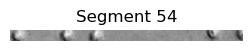

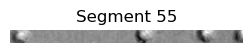

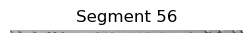

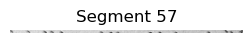

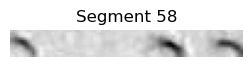

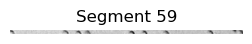

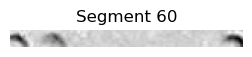

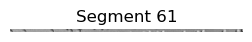

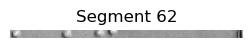

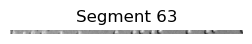

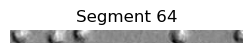

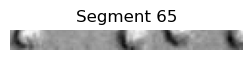

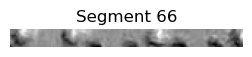

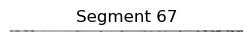

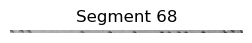

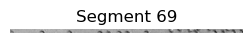

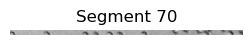

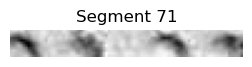

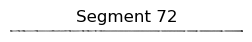

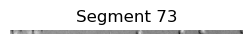

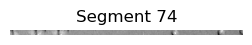

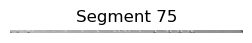

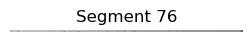

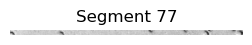

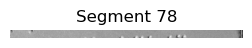

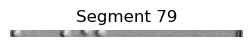

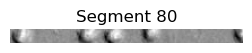

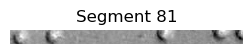

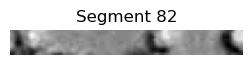

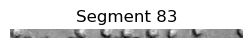

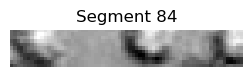

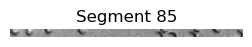

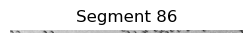

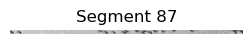

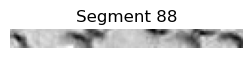

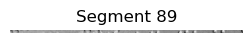

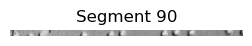

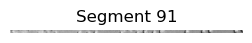

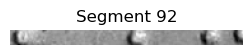

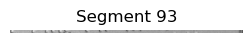

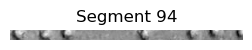

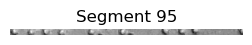

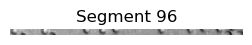

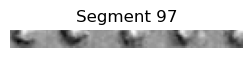

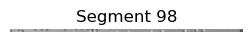

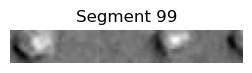

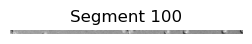

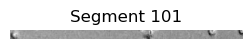

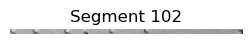

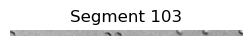

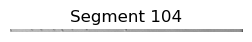

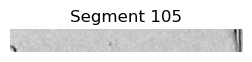

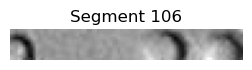

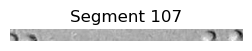

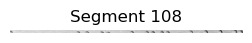

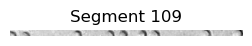

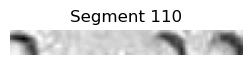

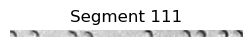

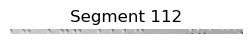

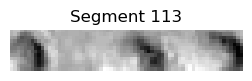

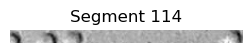

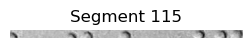

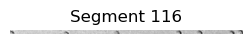

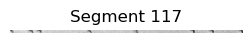

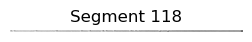

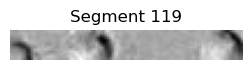

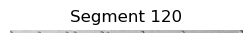

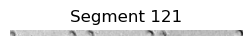

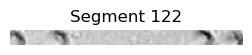

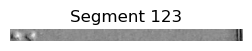

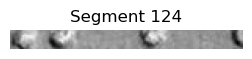

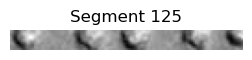

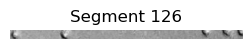

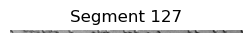

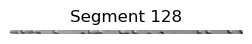

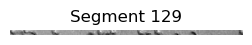

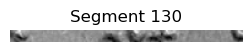

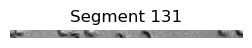

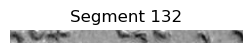

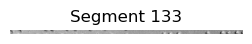

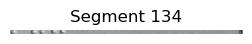

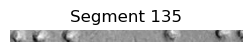

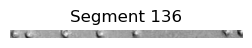

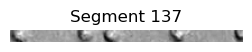

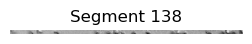

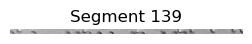

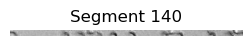

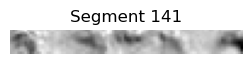

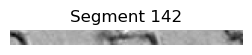

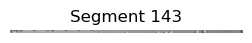

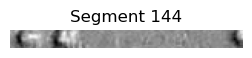

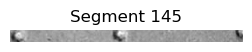

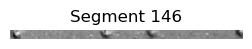

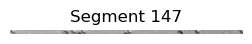

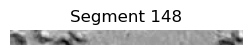

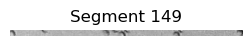

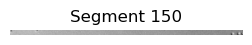

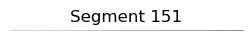

In [14]:
import cv2
import numpy as np
from scipy.cluster.hierarchy import fclusterdata
import matplotlib.pyplot as plt

# Read image in grayscale
image = cv2.imread("b9.jpg", cv2.IMREAD_GRAYSCALE)

output_image = image.copy()
output_image2 = image.copy()

h, w = image.shape

# Resize image to standardize
if w > 100:
    new_w = 100
    ar = w / h
    new_h = int(new_w / ar)
    img = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

# Gamma correction to enhance image visibility
def gamma_correction(image, gamma=2.5):
    normalized = image / 255.0
    corrected = np.power(normalized, gamma)
    return (corrected * 255).astype(np.uint8)

corrected_image = gamma_correction(image, gamma=4)

# Thresholding using adaptive Gaussian method
def thresholding(image):
    blur = cv2.GaussianBlur(image, (7, 7), 0)
    thresh = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 3)
    return thresh

thresh_img = thresholding(corrected_image)

# Denoise the image using morphological operations
def remove_noise(image, kernel_size=3, min_size=50):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    denoised = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(denoised, connectivity=8)
    output = np.zeros_like(denoised)

    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            output[labels == i] = 255
    return output

denoised_image = remove_noise(thresh_img, kernel_size=3, min_size=30)

# Detect contours and group them based on their centroids
def detect_and_group_dots(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    return centroids

# Use a 2x3 grid to identify the Braille dots
def group_dots_into_grid(centroids, grid_size=(2, 3), distance_threshold=30):
    # Sort centroids based on their x and y coordinates to align them in a grid-like structure
    centroids = sorted(centroids, key=lambda x: (x[1], x[0]))  # Sort by Y, then X

    # Calculate the expected grid positions (2x3 grid)
    grid_centroids = []
    rows = []
    for i, (x, y) in enumerate(centroids):
        if i % grid_size[1] == 0 and i > 0:  # every new row
            rows.append(grid_centroids)
            grid_centroids = []
        grid_centroids.append((x, y))
    rows.append(grid_centroids)

    # Create bounding boxes around the grid
    segments = []
    for row in rows:
        x_min = min([x for x, y in row])
        y_min = min([y for x, y in row])
        x_max = max([x for x, y in row])
        y_max = max([y for x, y in row])
        
        # Add some margin around the detected area
        margin = 5
        x_min -= margin
        y_min -= margin
        x_max += margin
        y_max += margin

        segment = image[y_min:y_max, x_min:x_max]
        segments.append(segment)

        # Draw bounding boxes on the output image
        cv2.rectangle(output_image2, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)

    return segments

# Detect and group dots into 2x3 grids
centroids = detect_and_group_dots(denoised_image)
segments = group_dots_into_grid(centroids)

# Display segmented Braille characters
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Braille Image with Bounding Boxes")
plt.show()

# Display each detected Braille character segment
for i, segment in enumerate(segments):
    plt.figure(figsize=(3, 3))
    plt.imshow(segment, cmap='gray')
    plt.axis('off')
    plt.title(f'Segment {i + 1}')
    plt.show()
